# AP4 - Pattern Recognition
Implementation of Naive Bayes and Linear Discriminant Analysis(LDA) for classification.

> Name: Jonas Carvalho Fortes

> Mat: 494513

## Load Datasets

In [79]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

dataset_input1 = loadmat('data/Input1.mat')
dataset_input1 = pd.DataFrame(dataset_input1['Input1']).transpose()
print(f'Dataset Input1 shape: {dataset_input1.shape}')

dataset_input2 = loadmat('data/Input2.mat')
dataset_input2 = pd.DataFrame(dataset_input2['Input2']).transpose()
print(f'Dataset Input2 shape: {dataset_input2.shape}')

Dataset Input1 shape: (4000, 2)
Dataset Input2 shape: (4000, 2)


In [80]:
# Create labels for the classes (1 for samples 1-2000, 2 for 2001-4000)
labels = np.array([1]*2000 + [2]*2000)

In [81]:
print('Dataset Input1:')
dataset_input1

Dataset Input1:


,0,1
0,0.545786,1.187656
1,0.369962,1.190989
2,1.713438,-0.191912
3,1.455538,0.378509
4,1.218019,0.646772
...,...,...
3995,0.458675,-1.473266
3996,-0.177021,-1.730604
3997,0.309656,-1.767054
3998,0.913877,-1.752652


In [82]:
print('Dataset Input2:')
dataset_input2

Dataset Input2:


,0,1
0,0.686500,0.494410
1,0.760307,0.609878
2,0.053486,0.811601
3,1.173823,0.359015
4,0.328171,0.907802
...,...,...
3995,0.392458,0.208384
3996,-0.127486,-0.190746
3997,0.057968,-0.320305
3998,1.639673,0.866730


## Helper functions and classes

### Naive Bayes Classifier Modeling

In [94]:
class NaiveBayesClassifier:
    
    def __init__(self):
        # Initialize the mean and variance for each class
        self.mean_class1 = None
        self.var_class1 = None
        self.mean_class2 = None
        self.var_class2 = None
    
    def fit(self, X, y):
        # Separate the samples for each class
        X_class1 = X[y == 1]
        X_class2 = X[y == 2]
        
        # Calculate the mean and variance for each class
        self.mean_class1 = X_class1.mean(axis=0)
        self.var_class1 = X_class1.var(axis=0)
        
        self.mean_class2 = X_class2.mean(axis=0)
        self.var_class2 = X_class2.var(axis=0)
    
    # Calculate the Gaussian probability
    def gaussian_probability(self, x, mean, var):
        exponent = np.exp(- ((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent
    
    def predict(self, X):
        predictions = []
        
        for i in range(X.shape[0]):
            sample = X.iloc[i, :]
            # Calculate the probability for Class 1
            prob_class1 = np.prod(self.gaussian_probability(sample, self.mean_class1, self.var_class1))
            # Calculate the probability for Class 2
            prob_class2 = np.prod(self.gaussian_probability(sample, self.mean_class2, self.var_class2))
            
            # Compare the probabilities and assign the class (1 or 2) with the highest probability
            if prob_class1 > prob_class2:
                predictions.append(1)
            else:
                predictions.append(2)
        
        return np.array(predictions)

### LDA Classifier Modeling

In [95]:
class LDAClassifier:
    
    def __init__(self):
        self.w = None  # projection vector (LDA direction)
        self.threshold = None  # decision threshold
    
    def fit(self, X, y):
        # Separate the samples for each class
        X_class1 = X[y == 1]
        X_class2 = X[y == 2]
        
        # Calculate the mean for each class
        mean_class1 = np.mean(X_class1, axis=0)
        mean_class2 = np.mean(X_class2, axis=0)
        
        # Calculate the covariance matrices for each class
        S1 = np.cov(X_class1, rowvar=False)
        S2 = np.cov(X_class2, rowvar=False)
        
        # Calculate the within-class scatter matrix
        Sw = S1 + S2
        
        # Calculate the projection vector w = Sw^(-1) * (mean_class1 - mean_class2)
        self.w = np.linalg.inv(Sw).dot(mean_class1 - mean_class2)
        
        # Project the class means onto the projection vector
        mean1_proj = np.dot(mean_class1, self.w)
        mean2_proj = np.dot(mean_class2, self.w)
        
        # Calculate the decision threshold
        self.threshold = (mean1_proj + mean2_proj) / 2
    
    def predict(self, X):
        # Project the samples onto the projection vector
        X_proj = np.dot(X, self.w)
        
        # Classify the samples based on the projection values and the decision threshold
        predictions = np.where(X_proj > self.threshold, 1, 2)
        return predictions

### Auxiliary Functions

In [96]:
import matplotlib.pyplot as plt

def plot_2d_scatter(X, y, title, model_nb=None, model_lda=None):
    """
    Plot a 2D scatter plot of the input data with decision boundaries.

    Parameters:
    - X: DataFrame or Array-like with the input data (continuous features).
    - y: Array-like with the target labels.
    - title: String with the title of the plot.
    - model_nb: Trained Naive Bayes model (optional).
    - model_lda: Trained LDA model (optional).
    """
    plt.figure(figsize=(10, 6))
    
    # Plot Class 1 as blue
    plt.scatter(X[y == 1].iloc[:, 0], X[y == 1].iloc[:, 1], color='blue', label='Class 1', alpha=0.6)
    
    # Plot Class 2 as red
    plt.scatter(X[y == 2].iloc[:, 0], X[y == 2].iloc[:, 1], color='red', label='Class 2', alpha=0.6)
    
    # Configure the plot
    plt.title(f'Scatter Plot 2D - {title}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [97]:
def plot_decision_boundary(X, y, model_class, title, **model_params):
    """
    Trains a model, makes predictions, and plots the decision boundary using meshgrid.

    Parameters:
    - X: DataFrame with the continuous features.
    - y: Array-like with the labels.
    - model_class: Class of the model to be trained (ex: NaiveBayesClassifier or LDAClassifier).
    - title: Title of the plot.
    - model_params: Parameters to be passed to the model during initialization.
    """
    # fit the model
    model = model_class(**model_params)
    model.fit(X, y)

    # Creating meshgrid
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # Convert meshgrid to DataFrame
    input_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)

    # make predictions
    Z = model.predict(input_data)
    Z = Z.reshape(xx.shape)

    # plot the decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Paired")

    # plot the samples
    plt.scatter(X[y == 1].iloc[:, 0], X[y == 1].iloc[:, 1], color='blue', label='Class 1', alpha=0.6)
    plt.scatter(X[y == 2].iloc[:, 0], X[y == 2].iloc[:, 1], color='red', label='Class 2', alpha=0.6)

    # Configure the plot
    plt.title(f'Decision Boundary - {title}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.grid(True)
    plt.show()

In [98]:
from sklearn.metrics import accuracy_score

def k_fold_cross_validation(X, y, k_folds, model_class):
    """
    Realiza K-fold cross-validation com o classificador especificado
    e retorna as métricas médias de cada fold.

    Args:
        X (np.ndarray): Input data.
        y (np.ndarray): Labels.
        k_folds (int): Numero de folds.
        model_class (class): Classes of the model to be used.(ex: NaiveBayesClassifier, LDAClassifier).

    Returns:
        dict: Dictionary with the average and standard deviation of the accuracy.

    """

    # Split the data into k_folds
    fold_size = len(y) // k_folds
    folds_X = [X[i * fold_size:(i + 1) * fold_size] for i in range(k_folds)]
    folds_y = [y[i * fold_size:(i + 1) * fold_size] for i in range(k_folds)]

    # List to store the accuracies of each fold
    accuracies = []

    # iterate over the folds
    for i in range(k_folds):

        # Separete the data into train and test
        X_test = folds_X[i]
        y_test = folds_y[i]

        # Concatenate the other folds to create the training data
        X_train = np.concatenate([folds_X[j] for j in range(k_folds) if j != i], axis=0)
        y_train = np.concatenate([folds_y[j] for j in range(k_folds) if j != i], axis=0)

        # Create the model
        model = model_class()
        
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate the metrics
        accuracy = accuracy_score(y_test, y_pred)

        # Save the acurracies metrics
        accuracies.append(accuracy)


    # Calculate the mean and standard deviation of the metrics
    mean_accuracy = float(np.mean(accuracies).round(2))
    standard_deviation_accuracy = float(np.std(accuracies).round(2))

    return {
        'accuracy': f'{mean_accuracy * 100}%',
        'accuracy_std': f'{standard_deviation_accuracy * 100}%'
    }


## Evaluation Metrics with K-folds


### Model performances in 10-folds cross validation

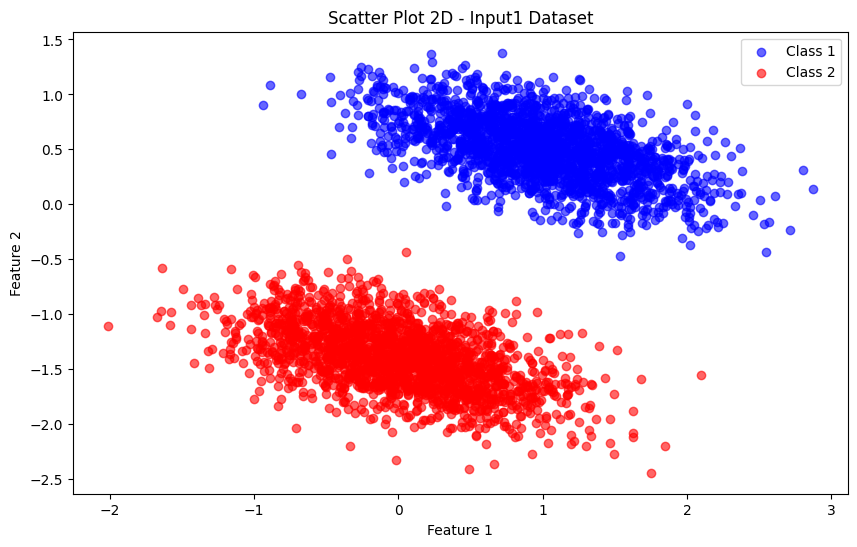

Results with Naive Bayes: {'accuracy': '100.0%', 'accuracy_std': '0.0%'}
Results with LDA: {'accuracy': '100.0%', 'accuracy_std': '0.0%'}


In [99]:
# Set the data into X and y
X = dataset_input1
y = labels

# Plot the scatter plot 2D for the input data 1
plot_2d_scatter(X, y, 'Input1 Dataset')

# Use NaiveBayesClassifier with 10-fold cross-validation for the input data 1
naive_bayes_results = k_fold_cross_validation(X, y, k_folds=10, model_class=NaiveBayesClassifier)
print("Results with Naive Bayes:", naive_bayes_results)

# Use LDAClassifier with 10-fold cross-validation for the input data 1
lda_results = k_fold_cross_validation(X, y, k_folds=10, model_class=LDAClassifier)
print("Results with LDA:", lda_results)

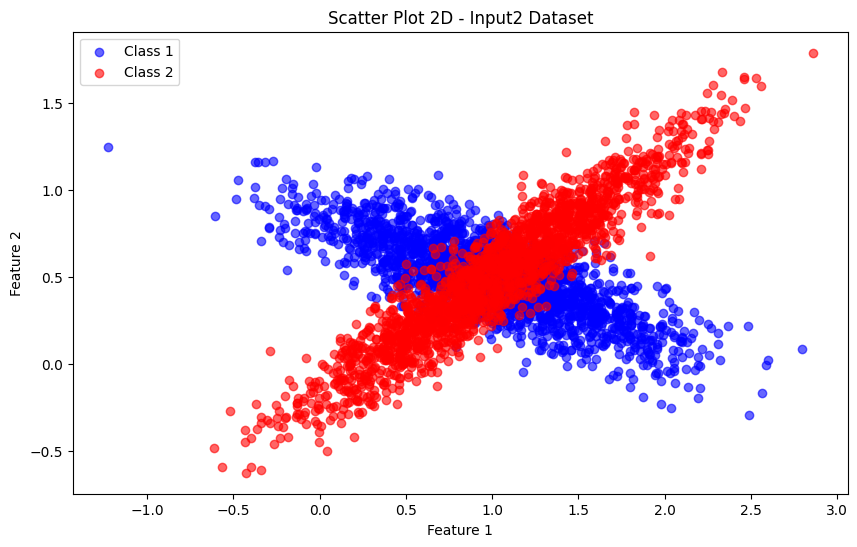

Resultados com Naive Bayes: {'accuracy': '63.0%', 'accuracy_std': '16.0%'}
Resultados com LDA: {'accuracy': '50.0%', 'accuracy_std': '3.0%'}


In [100]:
# Set the data into X and y
X = dataset_input2
y = labels

# Plot the scatter plot 2D for the input data 2
plot_2d_scatter(X, y, 'Input2 Dataset')

# Use NaiveBayesClassifier with 10-fold cross-validation for the input data 2
naive_bayes_results = k_fold_cross_validation(X, y, k_folds=10, model_class=NaiveBayesClassifier)
print("Resultados com Naive Bayes:", naive_bayes_results)

# Use LDAClassifier with 10-fold cross-validation for the input data 2
lda_results = k_fold_cross_validation(X, y, k_folds=10, model_class=LDAClassifier)
print("Resultados com LDA:", lda_results)


### Plot the boundary decisions

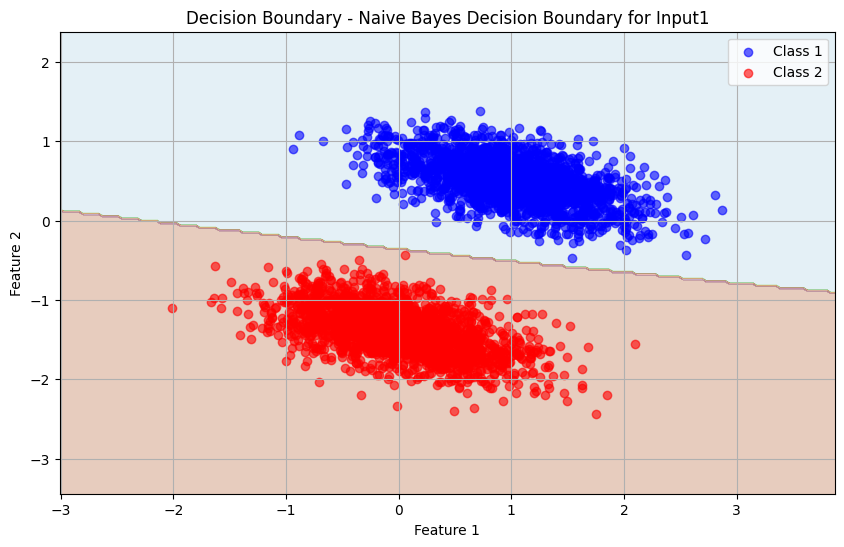

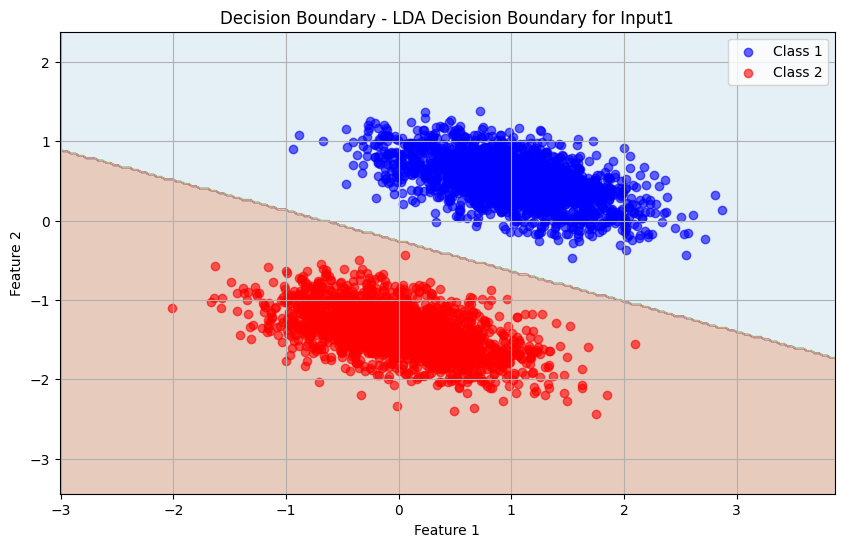

In [102]:
# Set the data into X and y
X = pd.DataFrame(dataset_input1)
y = labels

plot_decision_boundary(X, y, NaiveBayesClassifier, "Naive Bayes Decision Boundary for Input1")
plot_decision_boundary(X, y, LDAClassifier, "LDA Decision Boundary for Input1")

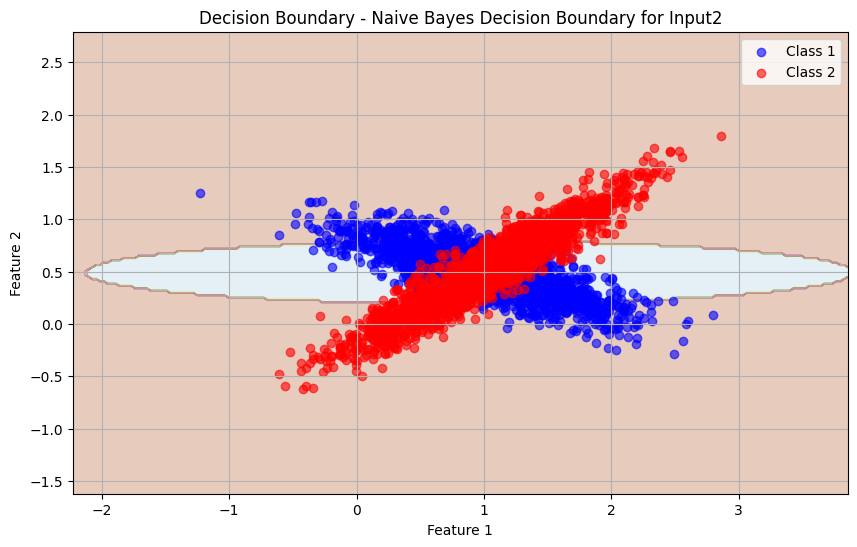

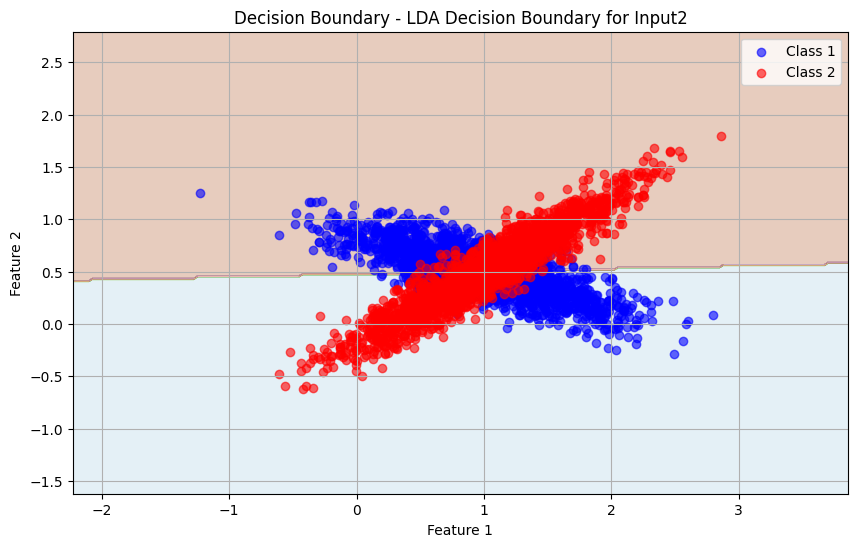

In [103]:
# Set the data into X and y
X = pd.DataFrame(dataset_input2)
y = labels

plot_decision_boundary(X, y, NaiveBayesClassifier, "Naive Bayes Decision Boundary for Input2")
plot_decision_boundary(X, y, LDAClassifier, "LDA Decision Boundary for Input2")

### Comments on model performances


> Como observado no gráfico de dispersão do dataset Input1, as classes estão muito bem separadas ocupando regiões distintas no espaço de atributos. Desse modo, uma vez que o classificador Bayesiano assume que os atributos são condicionalmente independentes dado as classes 1 e 2, e estima as probabilidades de cada classe com base na distribuição desses atributos, essa estimativa de independência se aproxima da realidade resultando em um alto desenpenho, o que justifica a acurácia de 100% para este dataset. E também, a ótima distribuição dos atributos neste dataset facilita que o classificador LDA crie uma fronteira de decisão que separe completamente as classes, também resultando em uma classificação perfeita.

> Em seguida, observa-se, no gráfico de dispersão do dataset Input2, que as classes muito mal separadas e as distribuições dos atributos estão sobrepostas, formando um padrão em X. Neste cenário, tanto o classificador Bayesiano quanto o LDA enfrentam desafios para a classificação: O classificador Bayesiano assume que os atributos são condicionalmente independentes dado as classes. No entanto, quando as distribuições das classes se sobrepõem em um padrão de X, essa suposição pode não reflete a estrutura real dos dados, resultando em uma acurácia de 60%. E também, o classificador LDA assume que as classes seguem distribuições normais com a mesma matriz de covariância, possibilitanto a definição de um vetor projeção, para encontrar o limiar de separação das classes. No entanto, as distribuições das classes estão sobrepostas e formam um padrões complexo, o que fez o classificador apresentar dificuldade para encontrar uma única linha de decisão que separe eficientemente as classes.